In [22]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

In [23]:
couponitemmapping = pd.read_csv('coupon_item_mapping.csv', delimiter=',',engine='python', header=0, encoding='latin-1')

In [24]:
couponitemmapping.head()

,coupon_id,item_id
0,105,37
1,107,75
2,494,76
3,522,77
4,518,77


In [25]:
item_data = pd.read_csv('item_data.csv', delimiter=',',engine='python', header=0, encoding='latin-1')

In [26]:
item_data.head()

,item_id,brand,brand_type,category
0,1,1,Established,Grocery
1,2,1,Established,Miscellaneous
2,3,56,Local,Bakery
3,4,56,Local,Grocery
4,5,56,Local,Grocery


In [27]:
items = item_data

In [28]:
items.loc[items['brand_type'].str.match('Local')==True,'brand_type'] = 0

In [29]:
items.loc[items['brand_type'].str.match('Established')==True,'brand_type'] = 1

In [30]:
from sklearn.preprocessing import LabelEncoder
number = LabelEncoder()
items['category'] = number.fit_transform(items['category'].astype('str'))

In [31]:
items.head()

,item_id,brand,brand_type,category
0,1,1,1,6
1,2,1,1,8
2,3,56,0,1
3,4,56,0,6
4,5,56,0,6


In [32]:
step1 = pd.merge(couponitemmapping, items, how='left', on='item_id')

In [33]:
customer_transaction_data = pd.read_csv('customer_transaction_data.csv', delimiter=',',engine='python', header=0, encoding='latin-1')

In [34]:
transactions = customer_transaction_data

In [35]:
transactions['redemption'] = 1
transactions.loc[transactions['coupon_discount']==0,'redemption'] = '0'
transactions.loc[transactions['other_discount']==0,'redemption'] = '0'

In [36]:
transactions['selling_price'] = transactions['selling_price']/transactions['quantity']
transactions['other_discount'] = transactions['other_discount']/transactions['quantity']
transactions['selling_price'] = transactions['selling_price'] - transactions['other_discount']

In [37]:
transactions = transactions.astype({"redemption": int})

In [38]:
transactions['date'] = pd.to_datetime(transactions['date'])
transactions = transactions.sort_values('date').reset_index(drop=True)

In [39]:
transactions['jour'] = transactions["date"].apply(lambda x: x.day)
transactions['week'] = transactions["date"].apply(lambda x: x.weekday())
transactions['mois'] = transactions["date"].apply(lambda x: x.month)

In [40]:
transactionsx1 = pd.pivot_table(transactions, index = "item_id",
                              values=['customer_id','quantity','selling_price', 'other_discount','coupon_discount','redemption'],
                              aggfunc={'customer_id':lambda x: len(set(x)),
                                       'quantity':np.mean,
                                       'selling_price':np.mean,
                                       'other_discount':np.mean,
                                       'coupon_discount':np.mean,
                                       'redemption': np.sum} )

In [41]:
transactionsx1.reset_index(inplace=True)
transactionsx1.rename(columns={'customer_id': 'nb_customers'}, inplace=True)

In [42]:
transactionsx2 = pd.pivot_table(transactions, index = "item_id",
                               values=['customer_id','quantity','selling_price', 'other_discount','coupon_discount'],
                                aggfunc={'customer_id':len,
                                         'quantity':np.sum,
                                         'selling_price':np.sum,
                                         'other_discount':np.sum,
                                         'coupon_discount':np.sum} )

In [43]:
transactionsx2.reset_index(inplace=True)
transactionsx2.rename(columns={'customer_id': 'tot_counts', 'quantity':'qua_sum','selling_price':'prix_sum', 'other_discount':'oth_sum','coupon_discount':'coup_sum'}, inplace=True)

In [44]:
transactionsx3 = pd.merge(transactionsx1, transactionsx2, on='item_id', how='left')

In [45]:
transactionsx3['total_dsc_mean'] = transactionsx3['coupon_discount'] + transactionsx3['other_discount']
transactionsx3['total_dsc_sum'] = transactionsx3['oth_sum'] + transactionsx3['coup_sum']
transactionsx3.head()

,item_id,coupon_discount,nb_customers,other_discount,quantity,redemption,selling_price,coup_sum,tot_counts,oth_sum,qua_sum,prix_sum,total_dsc_mean,total_dsc_sum
0,1,0.0,2,0.0,1.0,0,124.31,0.0,2,0.0,2,248.62,0.0,0.0
1,2,0.0,1,0.0,1.0,0,35.26,0.0,1,0.0,1,35.26,0.0,0.0
2,3,0.0,1,0.0,1.0,0,56.64,0.0,1,0.0,1,56.64,0.0,0.0
3,4,0.0,1,0.0,1.0,0,54.85,0.0,1,0.0,1,54.85,0.0,0.0
4,5,0.0,1,0.0,1.0,0,81.57,0.0,1,0.0,1,81.57,0.0,0.0


In [46]:
step2 = pd.merge(step1, transactionsx3, how='left', on='item_id')

In [47]:
from scipy.stats import mode

In [48]:
coupon_table = pd.pivot_table(step2, index ="coupon_id",
                        values=[ 'item_id', 'brand', 'brand_type', 'category',
                                'coupon_discount', 'redemption', 'nb_customers', 'other_discount',
                                'quantity', 'selling_price', 'coup_sum', 'tot_counts', 'oth_sum', 'qua_sum',
                                'prix_sum', 'total_dsc_mean', 'total_dsc_sum'],
                        aggfunc={'item_id':lambda x: len(set(x)),
                       'brand':lambda x: mode(x)[0][0],
                       'brand_type':lambda x: mode(x)[0][0],
                       'category':lambda x: mode(x)[0][0],
                       'coupon_discount':np.mean,
                       'nb_customers':np.mean,
                       'other_discount':np.mean,
                       'quantity':np.mean,
                       'selling_price':np.mean,
                      'redemption': np.sum,
                       'coup_sum': np.sum,
                       'tot_counts': np.sum,
                       'oth_sum': np.sum,
                       'qua_sum': np.sum,
                       'prix_sum': np.sum,
                       'total_dsc_mean': np.mean,
                       'total_dsc_sum': np.sum
                      })

In [49]:
coupon_table.reset_index(inplace=True)

In [50]:
coupon_table.rename(columns={'item_id':'item_counts'}, inplace=True)

In [51]:
coupon_table.rename(columns={'item_id':'nb_item_counts'}, inplace=True)

In [52]:
transactionsy3 = pd.pivot_table(transactions, index = "customer_id",
                                values=['item_id','quantity','selling_price', 'other_discount','coupon_discount','redemption','jour','week','mois'],
                                aggfunc={'item_id':lambda x: len(set(x)),
                                         'quantity':np.mean,
                                         'selling_price':np.mean,
                                         'other_discount':np.mean,
                                         'coupon_discount':np.mean,
                                         'redemption': np.sum,
                                         'jour':lambda x: mode(x)[0][0],
                                         'week':lambda x: mode(x)[0][0],
                                         'mois':lambda x: mode(x)[0][0]})

In [53]:
transactionsy3.reset_index(inplace=True)
transactionsy3.rename(columns={'item_id': 'nbo_items'}, inplace=True)
transactionsy3.head()

,customer_id,coupon_discount,nbo_items,jour,mois,other_discount,quantity,redemption,selling_price,week
0,1,-2.019876,463,3,5,-12.837537,1.170802,45,97.470480,3
1,2,-0.595084,352,13,6,-13.432195,1.131265,2,107.805783,5
2,3,-3.091546,406,16,7,-14.074853,11.578723,28,85.082452,4
3,4,-0.404773,125,14,5,-8.883656,1.272727,1,138.256770,5
4,5,-0.114684,490,11,5,-11.260696,117.869949,2,115.482842,1


In [54]:
transactionsy4 = pd.pivot_table(transactions, index = "customer_id",
                                values=['item_id','quantity','selling_price', 'other_discount','coupon_discount'],
                                aggfunc={'item_id':len,
                                         'quantity':np.sum,
                                         'selling_price':np.sum,
                                         'other_discount':np.sum,
                                         'coupon_discount':np.sum})

In [55]:
transactionsy4.reset_index(inplace=True)
transactionsy4.rename(columns={'item_id': 'cust_id_count','quantity':'qoa_sum','selling_price':'prec_sum',
                             'other_discount':'othe_sum','coupon_discount':'code_sum'  }, inplace=True)
transactionsy4.head()

,customer_id,code_sum,cust_id_count,othe_sum,qoa_sum,prec_sum
0,1,-2116.83,1048,-13453.738833,1227,102149.063000
1,2,-249.34,419,-5628.089833,474,45170.623167
2,3,-2179.54,705,-9922.771654,8163,59983.128347
3,4,-89.05,220,-1954.404333,280,30416.489333
4,5,-90.83,792,-8918.471477,93353,91462.410620


In [56]:
transactionsz = pd.merge(transactionsy3, transactionsy4, how='left',on='customer_id')
transactionsz.head()

,customer_id,coupon_discount,nbo_items,jour,mois,other_discount,quantity,redemption,selling_price,week,code_sum,cust_id_count,othe_sum,qoa_sum,prec_sum
0,1,-2.019876,463,3,5,-12.837537,1.170802,45,97.470480,3,-2116.83,1048,-13453.738833,1227,102149.063000
1,2,-0.595084,352,13,6,-13.432195,1.131265,2,107.805783,5,-249.34,419,-5628.089833,474,45170.623167
2,3,-3.091546,406,16,7,-14.074853,11.578723,28,85.082452,4,-2179.54,705,-9922.771654,8163,59983.128347
3,4,-0.404773,125,14,5,-8.883656,1.272727,1,138.256770,5,-89.05,220,-1954.404333,280,30416.489333
4,5,-0.114684,490,11,5,-11.260696,117.869949,2,115.482842,1,-90.83,792,-8918.471477,93353,91462.410620


In [57]:
campaign_data = pd.read_csv('campaign_data.csv', delimiter=',',engine='python', header=0, encoding='latin-1')

In [58]:
campaign = campaign_data

In [59]:
campaign.loc[campaign['campaign_type'].str.match('Y')==True,'campaign_type'] = 0

In [60]:
campaign.loc[campaign['campaign_type'].str.match('X')==True,'campaign_type'] = 1

In [61]:
campaign['duration'] = pd.to_datetime(campaign['end_date']) - pd.to_datetime(campaign['start_date'])

In [62]:
campaign['duration'] = campaign['duration'].dt.days

In [63]:
campaign['start_date'] = pd.to_datetime(campaign['start_date'], format = '%d/%m/%y')
campaign['end_date'] = pd.to_datetime(campaign['end_date'], format = '%d/%m/%y')

In [64]:
campaign = campaign.astype({"campaign_type": int})

In [65]:
customer_demographics = pd.read_csv('customer_demographics.csv', delimiter=',',engine='python', header=0, encoding='latin-1')

In [66]:
customer_demographics.head()

,customer_id,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,1,70+,Married,0,2,NaN,4
1,6,46-55,Married,0,2,NaN,5
2,7,26-35,NaN,0,3,1,3
3,8,26-35,NaN,0,4,2,6
4,10,46-55,Single,0,1,NaN,5


In [67]:
customerv2 = customer_demographics

In [68]:
customerv2.loc[customerv2['marital_status'].isna()==True,'marital_status'] = 'Single'

In [69]:
customerv2.head()

,customer_id,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,1,70+,Married,0,2,NaN,4
1,6,46-55,Married,0,2,NaN,5
2,7,26-35,Single,0,3,1,3
3,8,26-35,Single,0,4,2,6
4,10,46-55,Single,0,1,NaN,5


In [70]:
customerv2.loc[customerv2['no_of_children'].isna()==True]

,customer_id,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,1,70+,Married,0,2,NaN,4
1,6,46-55,Married,0,2,NaN,5
4,10,46-55,Single,0,1,NaN,5
5,11,70+,Single,0,2,NaN,1
6,12,46-55,Married,0,2,NaN,7
...,...,...,...,...,...,...,...
753,1573,46-55,Single,0,1,NaN,4
754,1574,36-45,Married,0,2,NaN,5
755,1577,36-45,Single,0,2,NaN,5
757,1579,46-55,Single,0,1,NaN,4


In [71]:
customerv2.loc[customerv2['no_of_children'].isna()==True,'no_of_children'] = '2'

In [72]:
customerv2.head()

,customer_id,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,1,70+,Married,0,2,2,4
1,6,46-55,Married,0,2,2,5
2,7,26-35,Single,0,3,1,3
3,8,26-35,Single,0,4,2,6
4,10,46-55,Single,0,1,2,5


In [73]:
dummies_v1 = pd.get_dummies(customerv2.age_range).add_prefix('cust_age_')

In [74]:
dummies_v2 = pd.get_dummies(customerv2.marital_status).add_prefix('cust_marit_')

In [75]:
dummies_v3 = pd.get_dummies(customerv2.no_of_children).add_prefix('cust_child_')

In [76]:
dummies_v4 = pd.get_dummies(customerv2.income_bracket).add_prefix('cust_inco_')

In [77]:
dummies_v5 = pd.get_dummies(customerv2.family_size).add_prefix('cust_fam_')

In [78]:
dummies_v3.head()

,cust_child_1,cust_child_2,cust_child_3+
0,0,1,0
1,0,1,0
2,1,0,0
3,0,1,0
4,0,1,0


In [79]:
cust_merged = pd.concat([customerv2, dummies_v1,dummies_v2,dummies_v3,dummies_v4,dummies_v5], axis='columns')

In [80]:
demographics = cust_merged.drop(['age_range', 'income_bracket','family_size','no_of_children','marital_status'], axis='columns')

In [81]:
demographics.head()

,customer_id,rented,cust_age_18-25,cust_age_26-35,cust_age_36-45,cust_age_46-55,cust_age_56-70,cust_age_70+,cust_marit_Married,cust_marit_Single,...,cust_inco_8,cust_inco_9,cust_inco_10,cust_inco_11,cust_inco_12,cust_fam_1,cust_fam_2,cust_fam_3,cust_fam_4,cust_fam_5+
0,1,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,1,0,0,0
1,6,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,7,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,8,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,10,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0


In [82]:
train_data = pd.read_csv('train.csv', delimiter=',',engine='python', header=0, encoding='latin-1')

In [83]:
train= train_data

In [84]:
test_data = pd.read_csv('test.csv', delimiter=',',engine='python', header=0, encoding='latin-1')

In [85]:
test = test_data

In [133]:
xx = pd.merge(train, coupon_table, on="coupon_id", how="left")
yy = pd.merge(xx, campaign, on="campaign_id", how="left")
zz = pd.merge(yy, demographics, on="customer_id", how="left")
ww = pd.merge(zz, transactionsz, on='customer_id', how='left')

In [134]:
ww

,id,campaign_id,coupon_id,customer_id,redemption_status,brand,brand_type,category,coup_sum,coupon_discount_x,...,other_discount_y,quantity_y,redemption_y,selling_price_y,week,code_sum,cust_id_count,othe_sum,qoa_sum,prec_sum
0,1,13,27,1053,0,1105,1,6,-5349.93,-1.241694,...,-25.583099,340.487097,1,163.966826,2,-89.05,310,-7930.760842,105551,50829.715972
1,2,13,116,48,0,56,0,6,0.00,0.000000,...,-20.013685,31.540260,4,188.638474,5,-1237.79,385,-7705.268702,12143,72625.812434
2,6,9,635,205,0,560,1,11,-605.54,-2.987321,...,-12.873370,1.392784,51,112.067666,2,-2145.72,970,-12487.169143,1351,108705.636349
3,7,13,644,1050,0,611,1,6,-17.81,-4.452500,...,-12.880868,1.291139,2,100.896997,4,-178.10,237,-3052.765833,306,23912.588333
4,9,8,1017,1489,0,1558,1,6,-569.92,-0.198055,...,-12.264174,247.443060,3,85.016352,4,-265.01,562,-6892.466021,139063,47779.189609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78364,128587,8,71,1523,0,56,0,6,0.00,0.000000,...,-8.282240,1.064935,0,119.448066,3,0.00,462,-3826.395000,492,55185.006667
78365,128589,30,547,937,0,2188,1,6,-35.62,-0.010943,...,-13.204228,1.206226,1,91.641946,6,-89.05,257,-3393.486667,310,23551.980000
78366,128590,8,754,1004,0,864,1,6,-6666.28,-3.239522,...,-11.887330,92.930028,4,99.589878,4,-260.03,1815,-21575.503851,168668,180755.627932
78367,128592,13,134,71,0,11,0,6,0.00,0.000000,...,-17.540946,19.131130,40,85.425052,6,-1325.04,938,-16453.407713,17945,80128.698841


In [135]:
ww.drop(['id','campaign_id','start_date','end_date'], axis=1, inplace=True)

In [136]:
ww = ww.dropna()

In [137]:
ww = ww.astype(float)

In [138]:
wiw = ww

In [120]:
#removing the variables to get the vif

In [139]:
wiw.drop(['coup_sum',
'coupon_discount_x',
'item_counts',
'oth_sum',
'other_discount_x',
'prix_sum',
'qua_sum',
'redemption_x',
'tot_counts',
'total_dsc_mean',
'total_dsc_sum',
'redemption_y',
'code_sum',
'cust_id_count',
'othe_sum',
'prec_sum'], axis=1, inplace=True)

In [122]:
y = wiw['redemption_status']
X = wiw.drop('redemption_status', axis = 1)

In [140]:
len(X)/len(y)

1.0

In [95]:
!pip3 install imblearn

In [96]:
import sklearn.metrics

In [97]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [98]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [99]:
from sklearn.datasets import load_diabetes

In [100]:
import sklearn
from sklearn.model_selection import train_test_split #sklearn import does not automatically install sub packages
from sklearn import linear_model
import statsmodels.api as sm

In [101]:
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [9]:
pip install --upgrade pip

  Attempting uninstall: pip
    Found existing installation: pip 21.2.4
    Uninstalling pip-21.2.4:
      Successfully uninstalled pip-21.2.4
Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install tensorflow

  Using cached protobuf-3.19.6-cp39-cp39-win_amd64.whl (895 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.1
    Uninstalling protobuf-3.20.1:
      Successfully uninstalled protobuf-3.20.1
Note: you may need to restart the kernel to use updated packages.


In [102]:
# Importing the Keras libraries and packages

pip install tensorflow

import keras
from keras.models import Sequential
from keras.layers import Dense



In [103]:
import tensorflow as tf

In [104]:
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense

In [141]:

# Feature Scaling Transformation to normalize the data
from sklearn.preprocessing import StandardScaler

#To train our the data
X_train = StandardScaler().fit_transform(X)


In [142]:
X_train

array([[-1.642571  ,  0.59009572,  0.03198812, ...,  3.47204535,
        -0.72932555, -0.28342388],
       [-1.37258233, -1.58585747, -0.75164392, ...,  4.8738445 ,
         1.03164718, -0.62163472],
       [ 0.20184598, -1.24593245, -0.37514197, ...,  0.52322745,
        -0.72932555, -0.66071029],
       ...,
       [-1.50909346,  1.60770567, -0.75164392, ...,  0.94256865,
        -0.14233464, -0.66382055],
       [-0.06510911,  0.33894092,  0.8410191 , ..., -0.63732566,
         1.6186381 , -0.66447953],
       [-1.31797788, -1.53605954, -0.78526017, ..., -0.99055849,
         1.6186381 , -0.60062689]])

In [144]:

#spliting our data into training and testing features and targets
from sklearn.model_selection import train_test_split 
X_train, X_vale, y_train, y_vale = train_test_split(X_train, y, test_size =0.3, random_state = 0)


In [145]:
X_val, X_test, y_val, y_test = train_test_split(X_vale, y_vale, test_size=0.5, random_state = 0)

In [128]:
X_train.shape

(30562, 48)

In [147]:
model = Sequential([
    Dense(32, activation='relu', input_shape=(48,)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid'),
])

model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [174]:
hist = model.fit(Xmodel_train, y_train,
          batch_size=32, epochs=100,
          validation_data=(X_val, y_val))

Epoch 1/100
956/956 [==============================] - 1s 868us/step - loss: 0.0433 - accuracy: 0.9874 - val_loss: 0.0527 - val_accuracy: 0.9875
Epoch 2/100
956/956 [==============================] - 1s 886us/step - loss: 0.0412 - accuracy: 0.9875 - val_loss: 0.0518 - val_accuracy: 0.9875
Epoch 3/100
956/956 [==============================] - 1s 806us/step - loss: 0.0405 - accuracy: 0.9875 - val_loss: 0.0515 - val_accuracy: 0.9875
Epoch 4/100
956/956 [==============================] - 1s 857us/step - loss: 0.0401 - accuracy: 0.9875 - val_loss: 0.0513 - val_accuracy: 0.9875
Epoch 5/100
956/956 [==============================] - 1s 944us/step - loss: 0.0398 - accuracy: 0.9875 - val_loss: 0.0515 - val_accuracy: 0.9876
Epoch 6/100
956/956 [==============================] - 1s 960us/step - loss: 0.0397 - accuracy: 0.9875 - val_loss: 0.0512 - val_accuracy: 0.9875
Epoch 7/100
956/956 [==============================] - 1s 890us/step - loss: 0.0395 - accuracy: 0.9876 - val_loss: 0.0513 - val_ac

In [175]:
model.evaluate(X_test, y_test)[1]

205/205 [==============================] - 0s 1ms/step - loss: 0.0659 - accuracy: 0.9837


0.9836640954017639

In [171]:
# Showing the inputs of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                1568      
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,657
Trainable params: 2,657
Non-trainable params: 0
_________________________________________________________________


In [191]:
y_prediction = model.predict(X_test)
y_prediction = (y_prediction 9)

205/205 [==============================] - 0s 544us/step


In [184]:
# Creating the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test)

In [185]:
cm

array([[6456,    0],
       [   0,   94]], dtype=int64)

In [192]:
import matplotlib.pyplot as plt

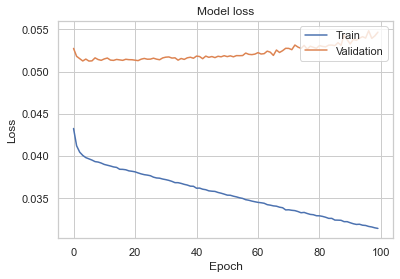

In [206]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

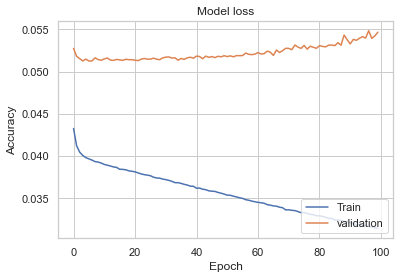

In [205]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='lower right')
plt.show()

In [199]:
plt.plot(hist_2.history['loss'])
plt.plot(hist_2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

NameError: name 'hist_2' is not defined

In [202]:
import numpy as np
X = np.random.rand(1000,10)
y = np.random.choice([1,0], size=1000)

In [203]:
# train/validation
training = model.fit(x=X, y=y, batch_size=32, epochs=100, shuffle=True, verbose=0, validation_split=0.3)

# plot
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]    
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,3))
       
## training    
ax[0].set(title="Training")    
ax11 = ax[0].twinx()    
ax[0].plot(training.history['loss'], color='black')    ax[0].set_xlabel('Epochs')    
ax[0].set_ylabel('Loss', color='black')    
for metric in metrics:        
    ax11.plot(training.history[metric], label=metric)    ax11.set_ylabel("Score", color='steelblue')    
ax11.legend()
        
## validation    
ax[1].set(title="Validation")    
ax22 = ax[1].twinx()    
ax[1].plot(training.history['val_loss'], color='black')    ax[1].set_xlabel('Epochs')    
ax[1].set_ylabel('Loss', color='black')    
for metric in metrics:          
    ax22.plot(training.history['val_'+metric], label=metric)    ax22.set_ylabel("Score", color="steelblue")    
plt.show()

SyntaxError: invalid syntax (1708947538.py, line 11)

NameError: name 'fit_dl_regr' is not defined